In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [3]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import hier_optimizor

from optimizor import eta_2_Gamma
from optimizor import Gamma_2_eta
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [37]:
# parameters for data
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 50
experiment = 1


if experiment == 1:
    
    Gamma = np.array([[0.9,0.05,0.05],
                      [0.05,0.9,0.05],
                      [0.05,0.05,0.9]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))
    
elif experiment == 2:
    
    Gamma = np.array([[0.99,0.005,0.005],
                      [0.005,0.99,0.005],
                      [0.005,0.005,0.99]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))

    
# optimization parameters 
methods = ["SAGA","EM","BFGS","CG"]
# methods = ["EM","SGD","SAG","SVRG","SAGA","GD","BFGS","Nelder-Mead"]

# pick optimization settings
step_sizes = {"EM"  : [None,None],
              "CG": [None,None],
              "BFGS": [None,None],
              "GD"  : [0.01,0.01],
              "SGD" : [0.01,0.01],
              "SAG" : [0.01,0.01],
              "SVRG": [0.01,0.01],
              "SAGA": [0.01,0.01]}

num_epochs = 50
tol = 1e-10
grad_tol = 1e-8

# Simulate Data

In [38]:
X = np.zeros(T,dtype=int)
data = []

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

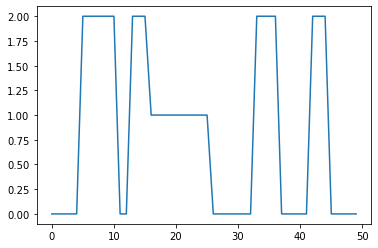

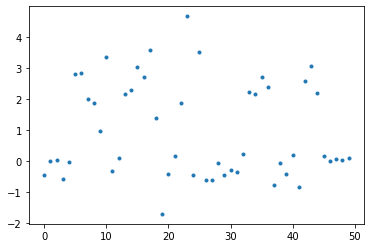

In [39]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# save data
np.savetxt('../dat/data.csv', 
           np.array([x['Y'] for x in data]), 
           delimiter=',')

# Train the HMM

In [40]:
importlib.reload(hier_optimizor)

# intialize HHMM
hhmm = HHMM.HHMM(pars,data)

hhmm.theta = [{'Y': {'mu': np.array([-1.0,  1.1,  2.1]),
                     'log_sig': np.array([0.0, 0.0, 0.0]),
                     'corr': np.zeros(pars.K[0])}},
               [{}, {}, {}]]

hhmm.Gamma = [Gamma,
             [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

hhmm.eta = Gamma_2_eta(hhmm.Gamma)

In [41]:
# initialize optims
optims = {}
times = {}

In [42]:
importlib.reload(hier_optimizor)
optim = hier_optimizor.optimizor(hhmm)

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/hier_optimizor.py:224: RuntimeWarning:

divide by zero encountered in true_divide

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/hier_optimizor.py:225: RuntimeWarning:

divide by zero encountered in true_divide

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/hier_optimizor.py:239: RuntimeWarning:

divide by zero encountered in double_scalars



In [43]:
optim.grad_eta0_G

[array([0., 0., 0.]), [array([0.]), array([0.]), array([0.])]]

In [46]:
for method in methods:
    
    for partial_E in [0,0.5,1]:
        
        if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
            continue
        
        print(method,partial_E)
        print("")

        optims[(method,partial_E)] = hier_optimizor.optimizor(hhmm)
        optims[(method,partial_E)].step_size = step_sizes[method]
        optims[(method,partial_E)].param_bounds["Y"]["mu"] = [-100,100]
        optims[(method,partial_E)].param_bounds["Y"]["log_sig"] = [-5,5]
        
        if not (step_sizes[method][0] is None):
            optims[(method,partial_E)].L_theta = 1.0 / step_sizes[method][0]
            optims[(method,partial_E)].L_eta = 1.0 / step_sizes[method][1]
        
        if partial_E == 0:
            optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                  method=method,
                                                  max_iters=T,
                                                  partial_E=False,
                                                  alpha_theta=step_sizes[method][0],
                                                  alpha_eta=step_sizes[method][1],
                                                  tol=tol,
                                                  grad_tol=grad_tol,
                                                  record_like = True)
        elif partial_E == 0.5:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)
        elif partial_E == 1:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=10*T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)

SAGA 0

starting epoch 0.0

starting E-step...
unidentified feature in y: subdive_features


TypeError: 'NoneType' object is not subscriptable

In [9]:
# get optimal value via EM:
optims["control"] = hier_optimizor.optimizor(hhmm)
optims["control"].step_size = [None,None]
optims["control"].param_bounds["Y"]["mu"] = [-100,100]
optims["control"].param_bounds["Y"]["log_sig"] = [-5,5]

optims["control"].train_HHMM(num_epochs=num_epochs,
                                      method="EM",
                                      tol=1e-15)
optim_ll = optims["control"].log_like_trace[-1]

NameError: name 'hhmm' is not defined

# Plot Results

In [10]:
def plot_ll(optims,x_time=False):
    
    ll_star = optims["control"].log_like_trace[-1]
    legend = []
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment,dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment,dpi=500)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    if method.startswith("SAGA"):
        x = (np.arange(iters) / optim.T)
    else:
        x = np.arange(iters)
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=300)
    plt.show()

    # plot means
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['mu'][k] for i in range(iters)])
        legend.append(r"$\mu^{(%d)}$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline, c = 'k', linestyle = "--")
        
    plt.title("$\mu$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot log(sigma)
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['log_sig'][k] for i in range(len(optim.theta_trace))])
        legend.append(r"$\log\left(\sigma^{(%d)}\right)$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline-1, c = 'k', linestyle = "--")
        
    plt.title(r"$\log\left(\sigma\right)$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot eta
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

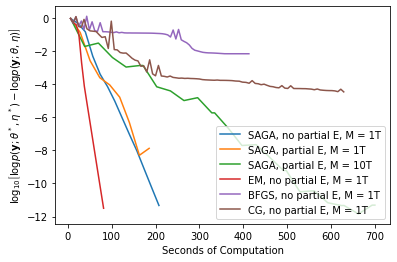

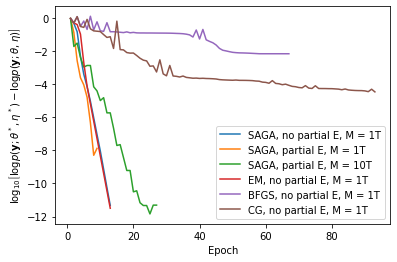

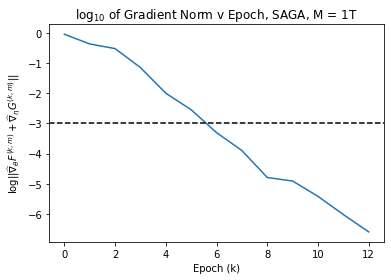

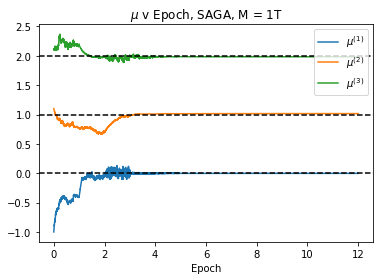

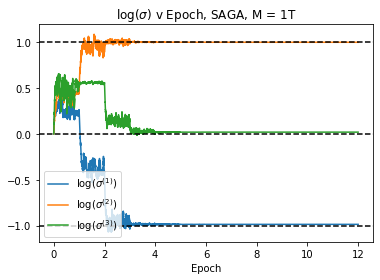

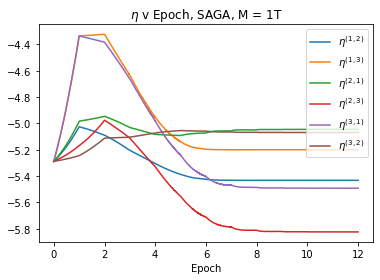

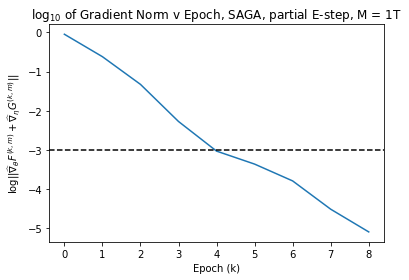

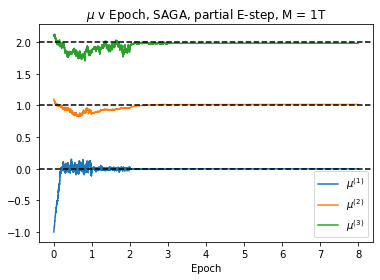

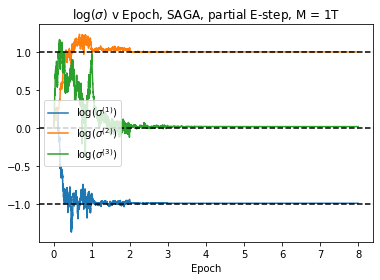

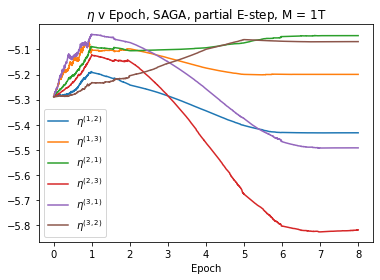

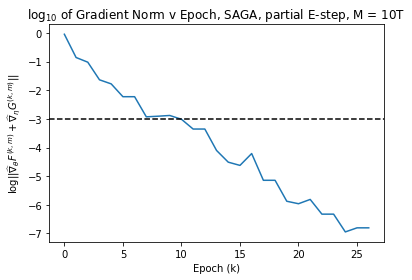

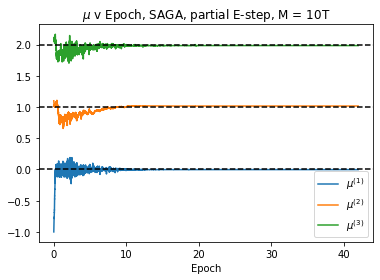

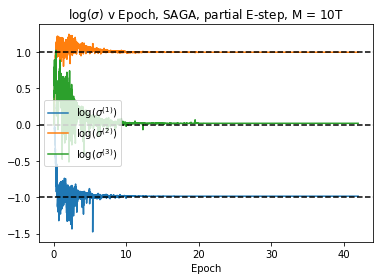

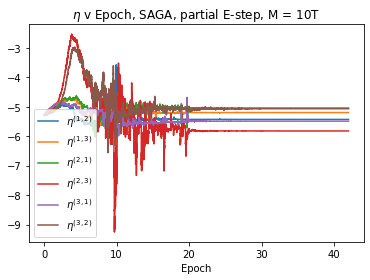

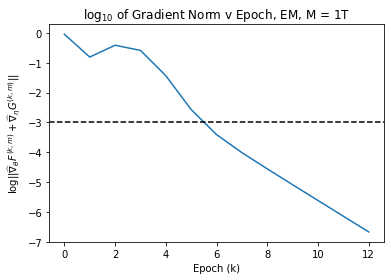

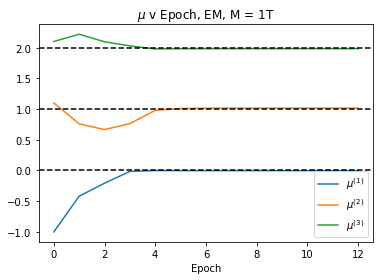

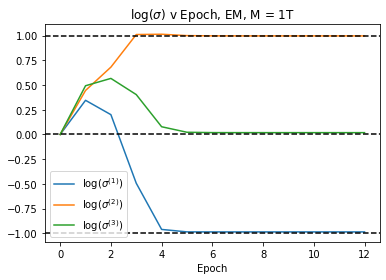

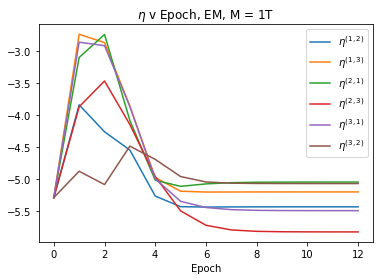

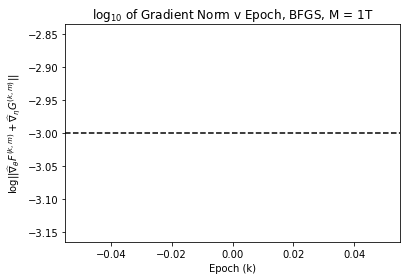

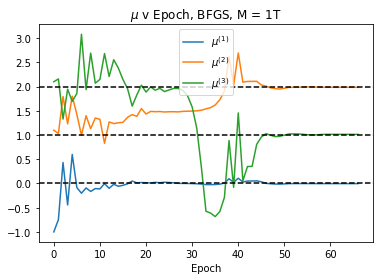

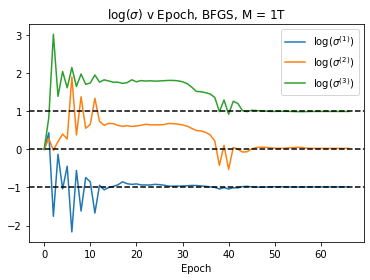

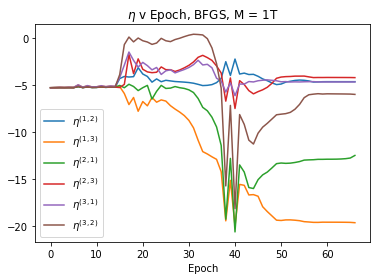

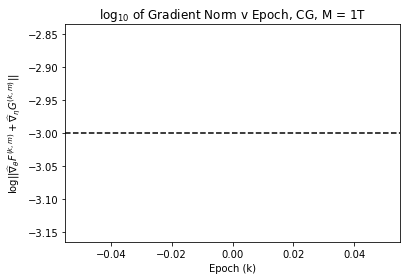

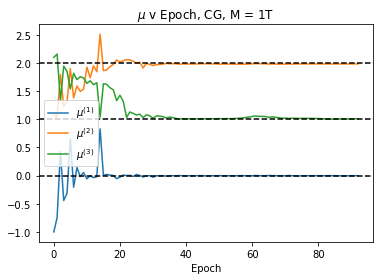

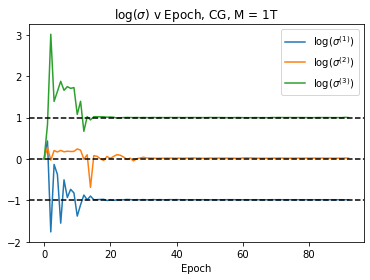

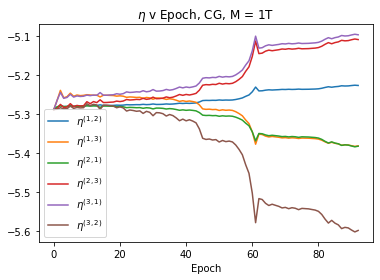

In [11]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],optim_ll,method,PE,M)